<a href="https://colab.research.google.com/github/guidoivetta/clustering-TM-2021/blob/main/Clustering_TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 78.4 MB 1.2 MB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-py3-none-any.whl size=79649483 sha256=2eec352573bb487c630b0cb7b79402bbaf7f00a54343469dec1d979e25ad521d
  Stored in directory: /tmp/pip-ephem-wheel-cache-htlg7o15/wheels/d8/f5/92/ee8a4f74fac67775fbc0314b1c9ae4694f4180437f6fc3dd1c
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import nltk
nltk.download('punkt')
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load dataset

In [2]:
nlp = spacy.load('es_core_news_md')

In [4]:
drive_path = '/content/drive/MyDrive/Text-Mining/'
filename = "lavoztextodump.txt"
text_file = open(drive_path+filename, "r")
dataset = text_file.read()
text_file.close()

In [5]:
doc = nlp(dataset[:1000000])

# Cleaning up dataset

Longer sentences are used because more interesting linguistic contructions are possible and the larger context provides more features for each word. 

In [6]:
# Only sents with more than 10 words are considered
longer_sents = [sent for sent in doc.sents if len(sent) > 10]

lemmas = []
for sent in longer_sents:
  for word in sent:
    if word.is_alpha:
      lemmas.append(word.lemma_)

# lemma_counter stores the number of times each lemma has ocurred
lemma_counter = Counter(lemmas)

# Adding features

Six groups of features are added: 

1.   Part-of-speech:

    * PROPN, AUX, VERB, ADP, etc.


2.   Dependency:

    * nsubj, aux, ROOT, prep, etc.


3.   Tag:

    * NNP, VBZ, VBG, NNP, etc.


4.   Dependency triples:

    * TRIPLE_pescado_nsubj_comer, etc.


5.   Entity Type:

    * GPE, PERSON, LOC, PERCENT, etc.


6.   Context:

    * All other lemmas in the same sent which surpass `threshold_c` are considered. If they are numerical values they are grouped in a `NUM__` feature.


Each distinct lemma in the dataset will have a count of each subfeature. This will be our guide to find word similarity and clusters in the rest of the notebook.

In [7]:
# features_dict has lemmas as keys and a dict with its features as values
features_dict = {}

# Lemmas with less than threshold_l number of ocurrences will not be considered
threshold_l = 10

# Context words with less than threshold_c number of ocurrences will not be considered
threshold_c = 50

for sent in longer_sents:
  for word in sent:
    l = word.lemma_
    if lemma_counter[l] < threshold_l or not word.is_alpha:
        continue
    
    if not l in features_dict:
      # New lemma
      l_features = {}
    else:
      # Known lemma, we must update its features
      l_features = features_dict[l]

    # Adding Part-of-speech feature
    pos = "POS__" + word.pos_
    if not pos in l_features:
        l_features[pos] = 0
    l_features[pos] += 1

    # Adding dependency feature
    dep = "DEP__" + word.dep_
    if not dep in l_features:
        l_features[dep] = 0
    l_features[dep] += 1

    # Adding tag feature
    tag = "TAG__" + word.tag_
    if not tag in l_features:
        l_features[tag] = 0
    l_features[tag] += 1

    # Adding dependency triples feature
    dep_triple = "TRIPLE_" + l + "_" + word.dep_ + "_" + word.head.lemma_
    if not dep_triple in l_features:
        l_features[dep_triple] = 0
    l_features[dep_triple] += 1

    # Adding entity type feature
    ent_type = word.ent_type_
    if ent_type is not '':
      if not ent_type in l_features:
        l_features[ent_type] = 0
      l_features[ent_type] += 1
    
    # Adding context feature
    # Here we define context as words in the same sent
    for other_word in sent:
      if other_word == word:
        continue
      if lemma_counter[other_word.lemma_] > threshold_c:
        if other_word.like_num:
          context = "NUM__"
        else:
          context = other_word.lemma_
        if not context in l_features:
            l_features[context] = 0
        l_features[context] += 1

    features_dict[l] = l_features

In [8]:
# features_matrix will have a similar structure as features_dict
# It will be used as input for a DictVectorizer
features_matrix = []

# lemma_dict has lemmas as keys and their lid (lemma id) as values
lemma_lid_dict = {}
wid = 0
for d in features_dict:
    if len(d) > 0:
        lemma_lid_dict[d] = wid
        wid += 1
        features_matrix.append(features_dict[d])

# Handling matrix

In [9]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features_matrix)

In [10]:
# Normalization is achieved by dividing by the matrix max value
matrix_normed = matrix / matrix.max(axis=0)

# Variances of each feature are calculated
variances = np.square(matrix_normed).mean(axis=0)-np.square(matrix_normed.mean(axis=0))

# Features with less variance than threshold_v will be discarded
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

# Data visualization

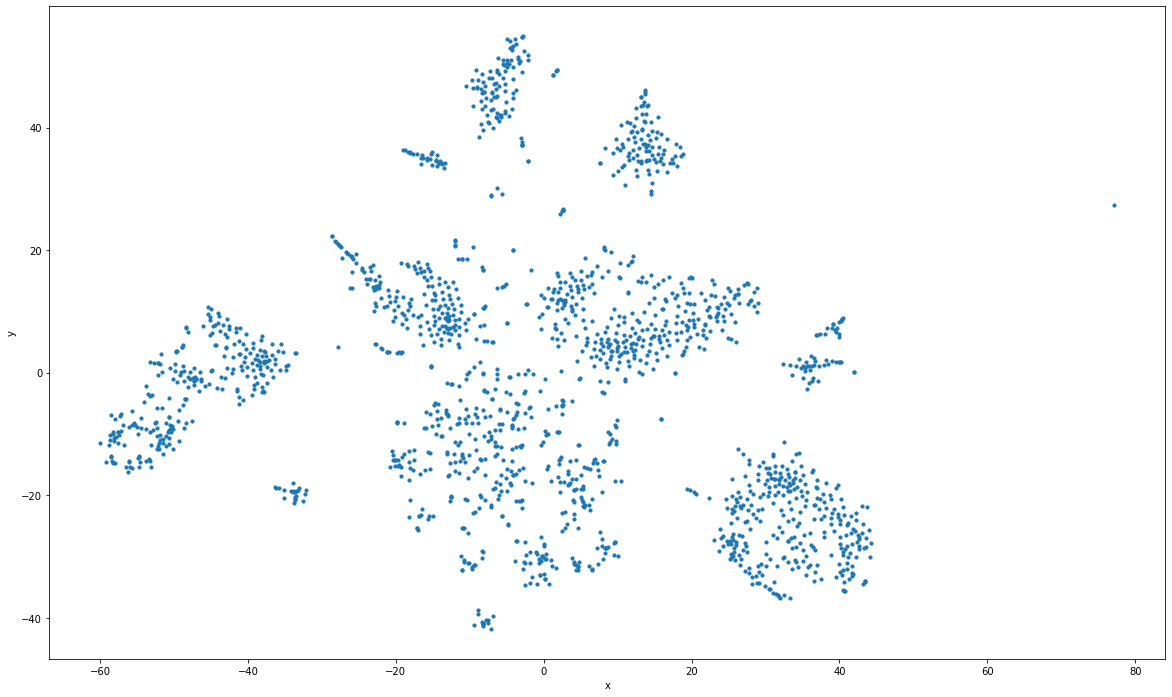

In [11]:
# t-SNE is used to visualize our high-dimensional red_matrix
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Clustering

In [12]:
def clustering(k, matrix):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance)
    clusters = clusterer.cluster(matrix, True)
    return clusters

# k-means with cosine distances is used for clustering
n_clusters = 150
clusters = clustering(n_clusters, red_matrix)

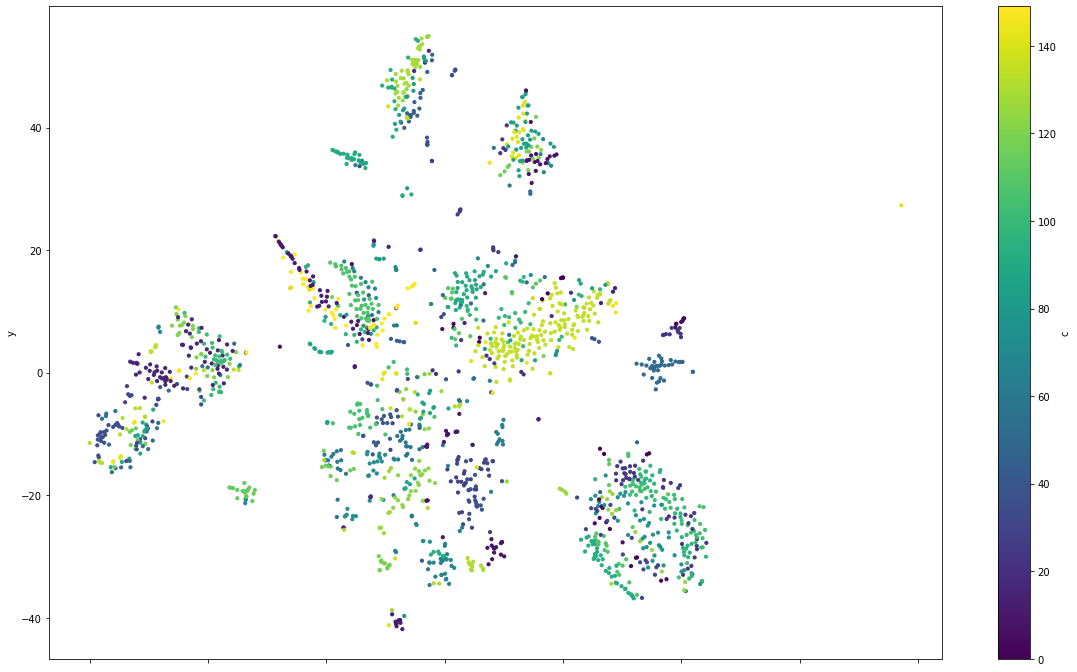

In [13]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [14]:
# Prints lemma's cluster and plots area around it
def show_neighbourhood(l, radius):
  pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
  )

  l_x = pointscluster.x[lemma_lid_dict[l]]
  l_y = pointscluster.y[lemma_lid_dict[l]]
  x_lower_bound = l_x-radius
  x_higher_bound = l_x+radius
  y_lower_bound = l_y-radius
  y_higher_bound = l_y+radius
  
  pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(10, 6))
  for i, point in pointscluster.iterrows():
    if x_lower_bound <= point.x <= x_higher_bound and y_lower_bound <= point.y <= y_higher_bound:
      plt.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=12)
  
  plt.xlim(x_lower_bound, x_higher_bound)
  plt.ylim(y_lower_bound, y_higher_bound)

  l_cluster = [lemma for lemma in lemma_lid_dict if clusters[lemma_lid_dict[lemma]] == clusters[lemma_lid_dict[l]]]

  print(f'Cluster for {l}:')
  print(f'\t{l_cluster}\n')

  print(f'Neighbourhood:\n')

Cluster for sábado:
	['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'julio', 'domingo']

Neighbourhood:



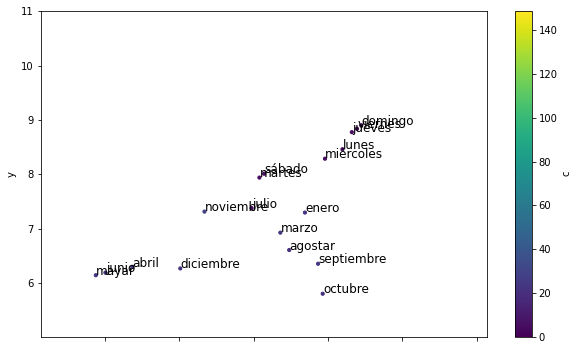

In [15]:
show_neighbourhood('sábado', radius=3)

Cluster for Facultad:
	['Ministerio', 'Córdoba', 'Villa', 'Facultad', 'Capital', 'Argentina', 'Provincia', 'Nación', 'Plaza', 'Universidad', 'Casa', 'Centro', 'Buenos', 'China', 'Estados', 'Brasilia', 'Brasil', 'Chile', 'Hospital', 'Tribunales', 'Conare', 'Quito', 'Madrid', 'Servicio']

Neighbourhood:



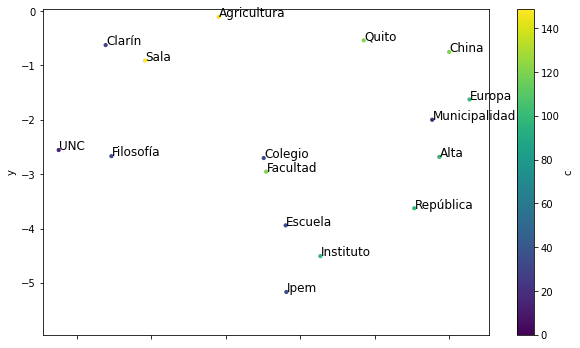

In [16]:
show_neighbourhood('Facultad', radius=3)

Cluster for Brasil:
	['Ministerio', 'Córdoba', 'Villa', 'Facultad', 'Capital', 'Argentina', 'Provincia', 'Nación', 'Plaza', 'Universidad', 'Casa', 'Centro', 'Buenos', 'China', 'Estados', 'Brasilia', 'Brasil', 'Chile', 'Hospital', 'Tribunales', 'Conare', 'Quito', 'Madrid', 'Servicio']

Neighbourhood:



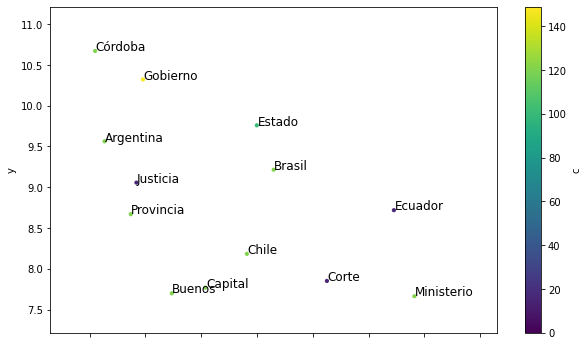

In [19]:
show_neighbourhood('Brasil', radius=2)

# Embeddings

## Word2Vec

In [20]:
from gensim.models import Word2Vec

sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(dataset[:1000000])]
model = Word2Vec(sentences, min_count=10)

In [21]:
model.wv.most_similar('lunes', topn=10)

[('contra', 0.9996324181556702),
 ('También', 0.9996229410171509),
 ('Con', 0.9995231628417969),
 ('mantener', 0.9995149970054626),
 ('internacional', 0.9995113611221313),
 ('tomas', 0.9994981288909912),
 ('docentes', 0.9994959235191345),
 ('cargo', 0.999493420124054),
 ('docente', 0.9994840025901794),
 ('empresarios', 0.9994829893112183)]

## SVD (Singular value decomposition)

In [22]:
from sklearn.decomposition import TruncatedSVD
# reducing data to 10 dimensions
svd = TruncatedSVD(n_components=10)
svd_matrix = svd.fit_transform(red_matrix)

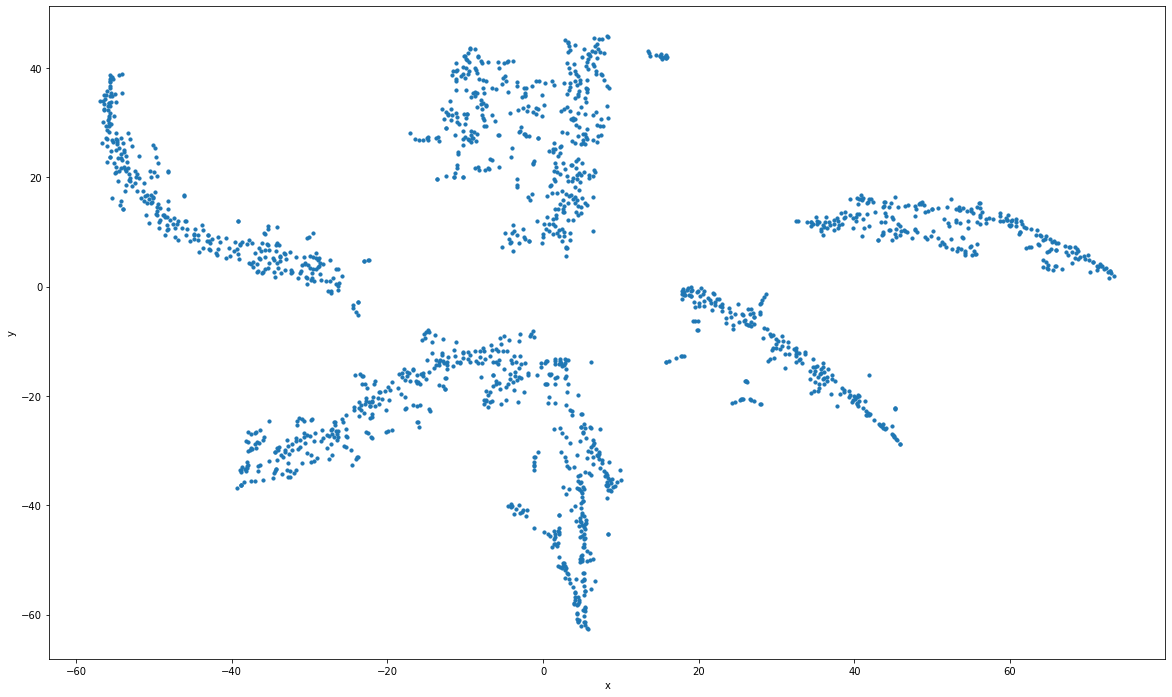

In [23]:
# t-SNE is used to visualize our high-dimensional svd_matrix
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(svd_matrix)

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y"]
)

pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [25]:
# k-means with cosine distances is used for clustering
n_clusters = 150
clusters_svd = clustering(n_clusters, svd_matrix)

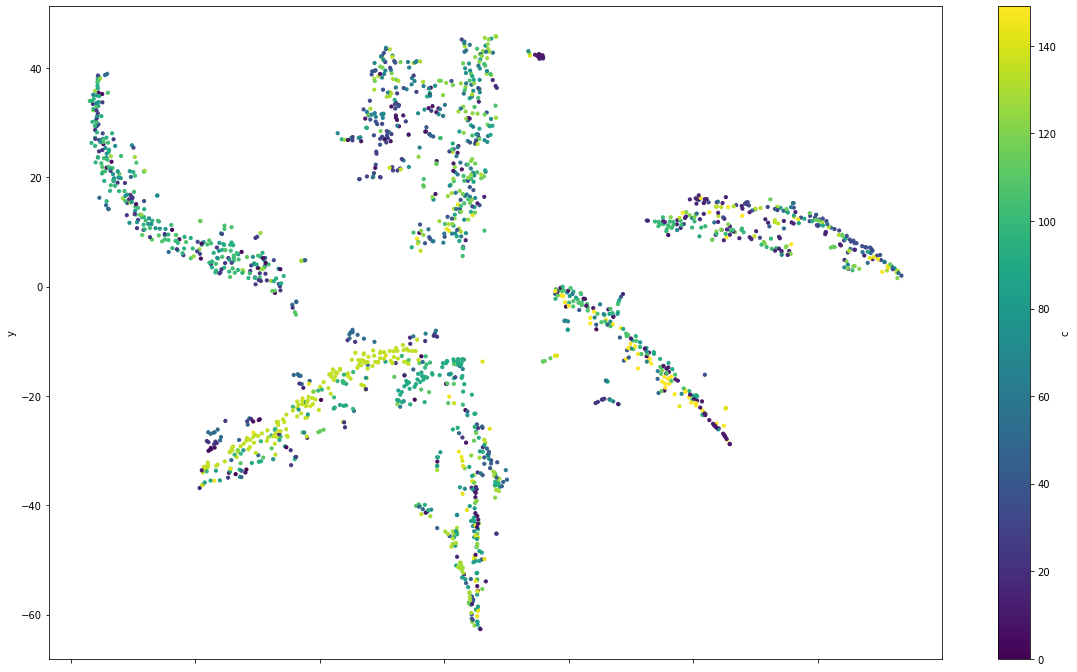

In [31]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[lemma_lid_dict[word]], clusters[lemma_lid_dict[word]])
            for word in lemma_lid_dict
        ]
    ],
    columns=["word", "x", "y", "c"]
)

pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

Cluster for sábado:
	['sábado', 'miércoles', 'martes', 'viernes', 'lunes', 'jueves', 'julio', 'domingo']

Neighbourhood:



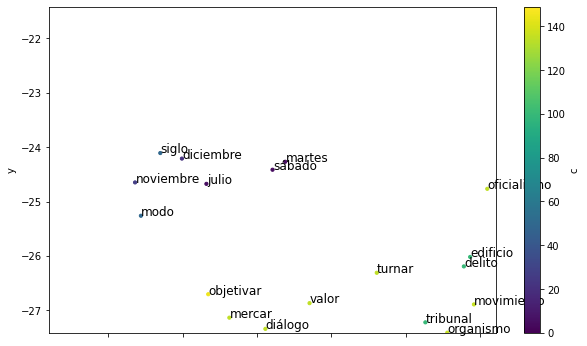

In [32]:
show_neighbourhood('sábado', radius=3)

Cluster for Facultad:
	['Ministerio', 'Córdoba', 'Villa', 'Facultad', 'Capital', 'Argentina', 'Provincia', 'Nación', 'Plaza', 'Universidad', 'Casa', 'Centro', 'Buenos', 'China', 'Estados', 'Brasilia', 'Brasil', 'Chile', 'Hospital', 'Tribunales', 'Conare', 'Quito', 'Madrid', 'Servicio']

Neighbourhood:



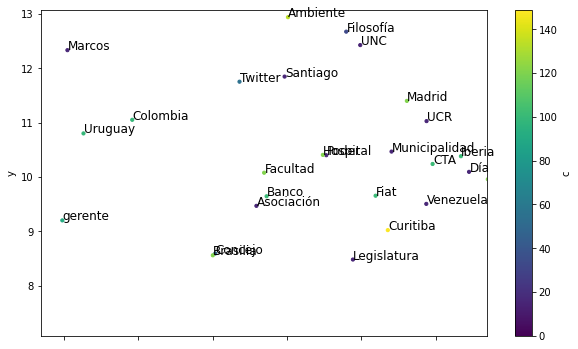

In [33]:
show_neighbourhood('Facultad', radius=3)

Cluster for Brasil:
	['Ministerio', 'Córdoba', 'Villa', 'Facultad', 'Capital', 'Argentina', 'Provincia', 'Nación', 'Plaza', 'Universidad', 'Casa', 'Centro', 'Buenos', 'China', 'Estados', 'Brasilia', 'Brasil', 'Chile', 'Hospital', 'Tribunales', 'Conare', 'Quito', 'Madrid', 'Servicio']

Neighbourhood:



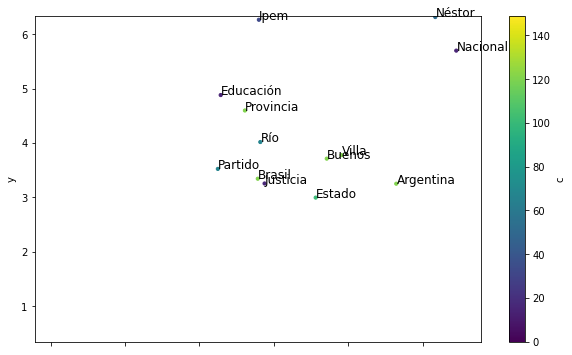

In [34]:
show_neighbourhood('Brasil', radius=3)

Cluster for Filosofía:
	['Carbó', 'Ipem', 'Belgrano', 'Jerónimo', 'Cabrera', 'Uno', 'Francia', 'Agulla', 'Escuela', 'Colegio', 'Filosofía']

Neighbourhood:



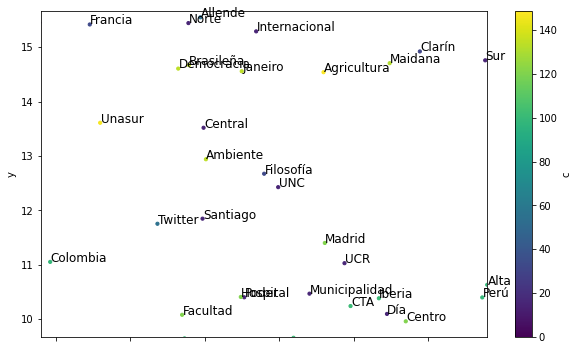

In [35]:
show_neighbourhood('Filosofía', radius=3)